Import packages
========================
We use pyro package in this tutorial  
For distribution, we use pyro.distributions in this tutorial, [click here](http://docs.pyro.ai/en/stable/distributions.html)
For transforms, we use pyro.distributions.transforms [click here](http://docs.pyro.ai/en/stable/distributions.html#distributions) for more detail

In [ ]:
pip install pyro-ppl

In [ ]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os
smoke_test = ('CI' in os.environ)

check the distribution and transformation
=====================
[Normalize Distribution](https://pytorch.org/docs/master/distributions.html#normal)  
We use $X$ as initial distribution

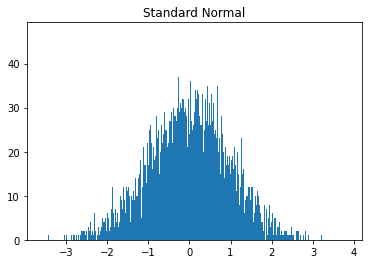

In [ ]:
dist_x = dist.Normal(torch.FloatTensor([0]), torch.FloatTensor([1]))
plt.hist(dist_x.sample([10000]).numpy(), bins=1000)
plt.title('Standard Normal')
plt.show()

we expect $Y = e^X$, so we use pyro.distributions.transforms package:  
$$g(x) = exp(x)$$
$$g^{-1}(y) = log(y)$$
$$log(|{\frac{dg}{dx}}|) = y$$

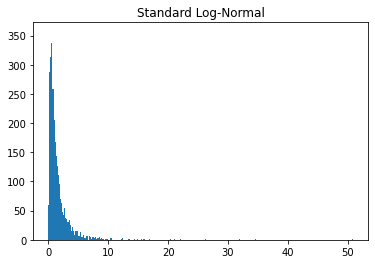

In [ ]:
exp_transform = T.ExpTransform()
dist_y = dist.TransformedDistribution(dist_x, [exp_transform])
plt.hist(dist_y.sample([10000]).numpy(), bins=1000)
plt.title('Standard Log-Normal')
plt.show()

affine transformation  
We can compose several transformation together.

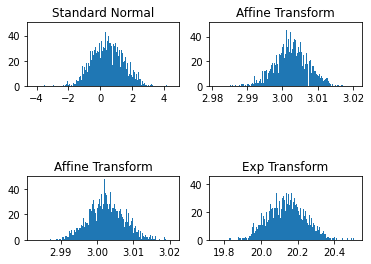

In [ ]:
# X
dist_x = dist.Normal(torch.FloatTensor([0.5]), torch.FloatTensor([1]))

# affine distribution
affine_transform = T.AffineTransform(loc=3, scale=0.005)

# Y after affine distribution
dist_y = dist.TransformedDistribution(dist_x, [affine_transform])

# plot Y
plt.subplot(3, 2, 1)
plt.hist(dist_x.sample([10000]).numpy(), bins=1000)
plt.title('Standard Normal')
plt.subplot(3, 2, 2)
plt.hist(dist_y.sample([10000]).numpy(), bins=1000)
plt.title('Affine Transform')

# exp distribution
exp_transform = T.ExpTransform()

# Z after affine distribution
dist_z = dist.TransformedDistribution(dist_y, [exp_transform])

# plot Z
plt.subplot(3, 2, 5)
plt.hist(dist_y.sample([10000]).numpy(), bins=1000)
plt.title('Affine Transform')
plt.subplot(3, 2, 6)
plt.hist(dist_z.sample([10000]).numpy(), bins=1000)
plt.title('Exp Transform')
plt.show()

univariate distribution
===================
[make_circles](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html)  
let's use ```make_circles``` to generate a real dataset

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 10000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)
X_1 = X[y==1]
X_0 = X[y==0]

print(f"X_0's shape is {X_0.shape}, X_1's shape is {X_1.shape}, y's shape is {y.shape}")

X_0's shape is (5000, 2), X_1's shape is (5000, 2), y's shape is (10000,)


let's plot

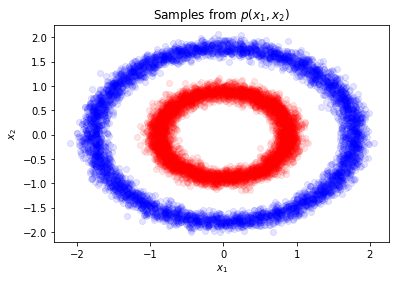

In [ ]:
plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X_1[:,0], X_1[:,1], alpha=0.1, c='red')
plt.scatter(X_0[:,0], X_0[:,1], alpha=0.1, c='blue')
plt.show()

test the distribution via [displot](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot)

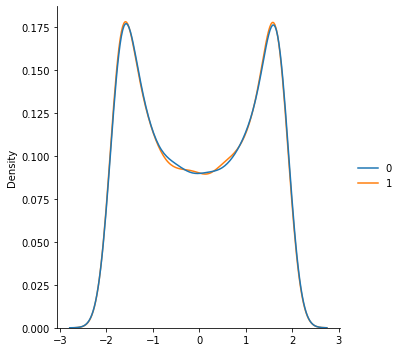

In [ ]:
sns.displot(X_0, kind='kde')

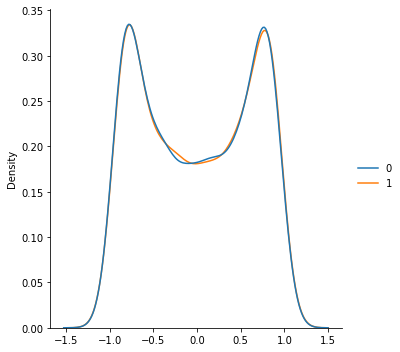

In [ ]:
sns.displot(X_1, kind='kde')

and we generate a 2-d Normal dataset (fake dataset) to train the transformation model ([Spline model](http://docs.pyro.ai/en/stable/distributions.html#spline)) so that the transformation could transform fake dataset to the real dataset.

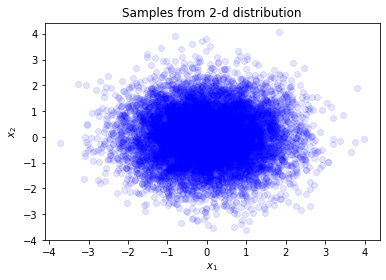

In [ ]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
plt.title(r'Samples from 2-d distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(base_dist.sample([10000])[:,0], base_dist.sample([10000])[:,1], alpha=0.1, c='blue')
plt.show()

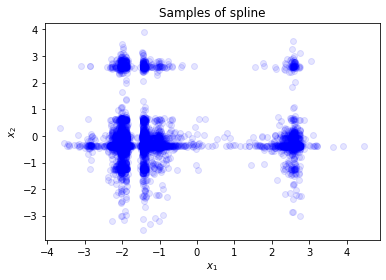

In [ ]:
spline_transform = T.Spline(2, count_bins=16, order='linear')
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])
Y = flow_dist.sample([10000])
plt.title(r'Samples of spline')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(Y[:,0], Y[:,1], alpha=0.1, c='blue')
plt.show()

Purely functional Pyro code typically creates ```Transform``` objects each model execution, then discards them after ```.backward()```, effectively clearing the transform caches. By contrast in this tutorial we create stateful module objects and need to manually clear their cache after update.

In [ ]:
%%time
steps = 1 if smoke_test else 1001
dataset = torch.tensor(X, dtype=torch.float) # real dataset
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 4.193314552307129
step: 200, loss: 1.355979084968567
step: 400, loss: 1.3021528720855713
step: 600, loss: 1.286319375038147
step: 800, loss: 1.2810536623001099
step: 1000, loss: 1.278742790222168
CPU times: user 14.1 s, sys: 220 ms, total: 14.4 s
Wall time: 14.4 s


draw the plot to check if the transformation method (Spline) really learn something and reflect any normal distribution to the real dataset

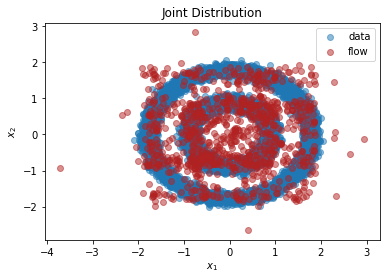

In [ ]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5) # plot the real dataset
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5) # plot the fake dataset
plt.legend()
plt.show()

multivariate distribution
=============================
[make_circles](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html)  
let's use ```make_circles``` to generate a real dataset  
The same as what we did in univariate distribution

In [ ]:
n_samples = 10000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)
X_1 = X[y==1]
X_0 = X[y==0]

print(f"X_0's shape is {X_0.shape}, X_1's shape is {X_1.shape}, y's shape is {y.shape}")

X_0's shape is (5000, 2), X_1's shape is (5000, 2), y's shape is (10000,)


let's plot the dataset again

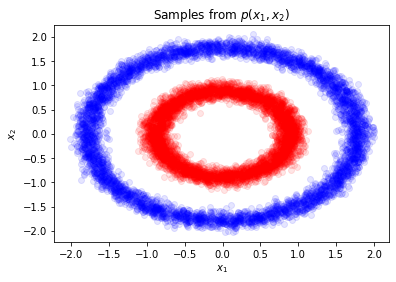

In [ ]:
plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X_1[:,0], X_1[:,1], alpha=0.1, c='red')
plt.scatter(X_0[:,0], X_0[:,1], alpha=0.1, c='blue')
plt.show()

make a learnable transformation [spline coupling](http://docs.pyro.ai/en/stable/distributions.html#splinecoupling) of the base distribution

In [ ]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

let's train it

In [ ]:
%%time
steps = 1 if smoke_test else 2001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 1.8196269273757935
step: 500, loss: 1.8096296787261963
step: 1000, loss: 1.7681822776794434
step: 1500, loss: 1.7725154161453247
step: 2000, loss: 1.775429129600525
CPU times: user 1min 43s, sys: 2.21 s, total: 1min 45s
Wall time: 1min 45s


plot the result

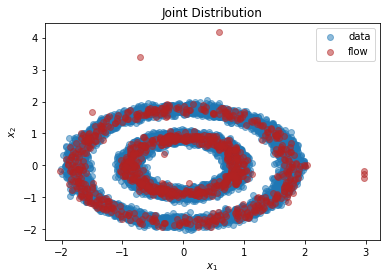

In [ ]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy() # the generated distribution (fake dataset) after training
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5) # plot the real dataset
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5) # plot the fake dataset
plt.legend()
plt.show()

test it using a new normal distribution

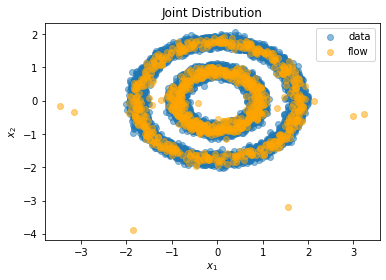

In [ ]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy() # the generated distribution (fake dataset) after training
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5) # plot the real dataset
plt.scatter(X_flow[:,0], X_flow[:,1], color='orange', label='flow', alpha=0.5) # plot the fake dataset
plt.legend()
plt.show()